In [74]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import numpy as np
from scipy.optimize import curve_fit
import jax
import jax.numpy as jnp
import tqdm
from joblib import Parallel, delayed
from itertools import product
from scipy.optimize import OptimizeWarning
import warnings

In [75]:
import sys
sys.path.insert(0, "/home/tfioratti/git/stockora/")
from stockora.shadow_clone import parallelize

In [76]:
def g_linspace(start, end, n_points):
    xi = np.linspace(-1, 1, n_points)
    return (start + end)/2 + (end - start)/2 * xi**3
def exp_decay(t, A, tau, C):
    return A * np.exp(-t / tau) + C

def calculate_norm(h_t):
    return jnp.sqrt(jnp.mean(h_t ** 2))

In [102]:
import jax
import jax.numpy as jnp
from jax.lax import scan
from jax import random, vmap
from functools import partial

def define_pars(key, hidden_size,  bias, vol, normalize=False):
    k1, k2, k3, k4, k5, k6, k7, k8 = random.split(key,8)

    scale_f = vol / jnp.sqrt(hidden_size) if normalize else vol
    b_scale = bias

    W_i = jax.random.normal(k1, (hidden_size, hidden_size)) * scale_f
    b_i = jax.random.normal(k5, (hidden_size,)) * b_scale
    W_f = jax.random.normal(k2, (hidden_size, hidden_size)) * scale_f
    b_f = jax.random.normal(k6, (hidden_size,)) * b_scale
    W_c = jax.random.normal(k3, (hidden_size, hidden_size)) * scale_f
    b_c = jax.random.normal(k7, (hidden_size,)) * b_scale
    W_o = jax.random.normal(k4, (hidden_size, hidden_size)) * scale_f
    b_o = jax.random.normal(k8, (hidden_size,)) * b_scale

    return W_i, b_i, W_f, b_f, W_c, b_c, W_o, b_o

def single_lstm_cell(key, hidden_size, bias, num_steps, vol, normalize=False):
    from jax.nn import sigmoid, tanh
    pars = define_pars(key, hidden_size,bias, vol, normalize)
    print(type(hidden_size))
    def f_scan(carry, _):
        h, c, W_i, b_i, W_f, b_f, W_c, b_c, W_o, b_o = carry
        z = h  # Usa solo h per l'evoluzione
        i = sigmoid(jnp.dot(z, W_i) + b_i)
        f = sigmoid(jnp.dot(z, W_f) + b_f)
        o = sigmoid(jnp.dot(z, W_o) + b_o)
        c_hat = tanh(jnp.dot(z, W_c) + b_c)
        
        c = f * c + i * c_hat
        h = o * tanh(c)
        return (h, c, W_i, b_i, W_f, b_f, W_c, b_c, W_o, b_o), h

    h0 = random.normal(key)*jnp.ones(hidden_size)
    c0 = jnp.zeros(hidden_size)
    initial_state = (h0, c0) + pars  
    xs = jnp.zeros((num_steps,))  
    final_state, outputs = scan(f_scan, initial_state, xs)
    return final_state, outputs

def LSTMCell_test(keys, hidden_size, bias, num_steps, vol, normalize=False):
    cell_fixed = partial(
        single_lstm_cell,
        hidden_size = hidden_size,
        bias = bias,
        num_steps = num_steps, 
        vol=vol, 
        normalize=normalize
    )
    batched_cell = vmap(cell_fixed)
    return batched_cell(keys)

In [ ]:
def compute_tau_vectorized(seeds, hidden_size, num_steps, b, g):
    _, output_sequences = LSTMCell_test(seeds,hidden_size, b, num_steps, g, normalize=False)

    def compute_single_tau(outputs):
        norms_over_time = jnp.array([calculate_norm(h_t) for h_t in outputs])
        fixed_points = jnp.mean(norms_over_time[-10:])
        norms_centered = jnp.abs(fixed_points - norms_over_time)
        return norms_centered

    norms_centered_all = vmap(compute_single_tau)(output_sequences)

    tau_list = []
    for norms_centered in norms_centered_all:
        norms_centered_np = np.array(norms_centered[5:])
        x_data = np.arange(num_steps - 5)
        popt, _ = curve_fit(exp_decay, x_data, norms_centered_np)
        tau = min(popt[1], num_steps)
        tau_list.append(tau)

    return jnp.array(tau_list)

In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random

key = jax.random.PRNGKey(0)
hidden_size = 1000
g_factors = jnp.linspace(0.5, 1.5, 40)  
g_critico = 2 / jnp.sqrt(hidden_size)
g = g_factors * g_critico  
num_steps = 1000
num_seeds = 1000  
bias_values = 0.0275 * jnp.linspace(1, 4, 20)  

seeds = random.split(key, num_seeds)

tau_mean = np.zeros((len(bias_values), len(g_factors)))

def compute_tau_combination(params, seeds, hidden_size, num_steps):
    b = params['b']
    g_factor = params['g_factor']
    results = compute_tau_vectorized(seeds, hidden_size, num_steps, b, g_factor)
    return b, g_factor, np.nanmean(results)


In [110]:

jobs = [{'b': float(b), 'g_factor': float(g_factor)} for b in bias_values for g_factor in g]

results = parallelize(
    exec_func=compute_tau_combination,
    jobs=jobs,
    single_arg = True,
    exec_kwargs=dict(seeds = seeds, hidden_size=hidden_size, num_steps=num_steps),
    mode="slurm",
    root_dir=f"/mnt/live/user/tfioratti/parallelize_test",
)

Graph tfioratti__parallelize_test posted. Follow the execution using the [grid view](https://srv006545.fr.cfm.fr:56006/graph/index.html#/manage/tfioratti__parallelize_test) or the [graph view](https://srv006545.fr.cfm.fr:56006/graph/index.html#/display/tfioratti__parallelize_test)

Exception: Graph tfioratti__parallelize_test stopped with final status FAILED!

import time

start = time.time()
params = {
    'b': float(bias_values[0]),
    'g_factor': float(g[0])
}

result = compute_tau_combination(params, seeds, hidden_size, num_steps)

end = time.time()

print(f"Tempo di esecuzione: {end - start} secondi")
print("Risultato:", result) #1693 secondi

In [ ]:
from pathlib import Path

root_dir = Path("/mnt/live/user/tfioratti/parallelize_test")
result_files = sorted(root_dir.glob("execution_results/*"))

tau_values = []

for result_file in result_files:
    data = np.load(result_file, allow_pickle=True)
    tau_values.append(data[2])  

tau_array = np.array(tau_values)


IndexError: string index out of range

In [ ]:
from pathlib import Path
results_dir = Path("/mnt/live/user/tfioratti/parallelize_test/execution_results")

result_files = sorted(results_dir.glob("*"), key=lambda x: int(x.stem))

data_dict = {}

for result_file in result_files:
    data = np.load(result_file, allow_pickle=True)
    tau_value = data[2]
    file_key = result_file.stem  
    data_dict[file_key] = tau_value


print(data_dict)

{'0': 1.9144398, '1': 2.0323195, '2': 2.1489747, '3': 2.2765923, '4': 2.415778, '5': 2.5728316, '6': 2.7710137, '7': 2.984253, '8': 3.241854, '9': 3.529389, '10': 3.891984, '11': 4.3455195, '12': 4.9057, '13': 5.6322784, '14': 6.607734, '15': 8.15671, '16': 10.931599, '17': 16.427261, '18': 27.711353, '19': 46.153748, '20': 60.657425, '21': 57.978638, '22': 61.827595, '23': 54.653053, '24': 49.367477, '25': 36.76855, '26': 25.423895, '27': 18.088087, '28': 14.765906, '29': 13.125857, '30': 12.151345, '31': 11.251224, '32': 9.020918, '33': 8.510078, '34': 8.180793, '35': 7.378625, '36': 7.2502637, '37': 6.6954074, '38': 6.7130466, '39': 6.49154, '40': 1.9092913, '41': 2.0153701, '42': 2.1404698, '43': 2.291751, '44': 2.4344342, '45': 2.6042647, '46': 2.7830017, '47': 2.9968977, '48': 3.2725918, '49': 3.5848334, '50': 3.9476316, '51': 4.377208, '52': 4.9155593, '53': 5.641745, '54': 6.672653, '55': 8.207098, '56': 10.798203, '57': 16.12939, '58': 26.44619, '59': 43.57238, '61': 58.931236

In [122]:
full_range_keys = [str(i) for i in range(800)]

tau_values_list = [data_dict.get(key, np.nan) for key in full_range_keys]

tau_array = np.array(tau_values_list).reshape(20, 40)


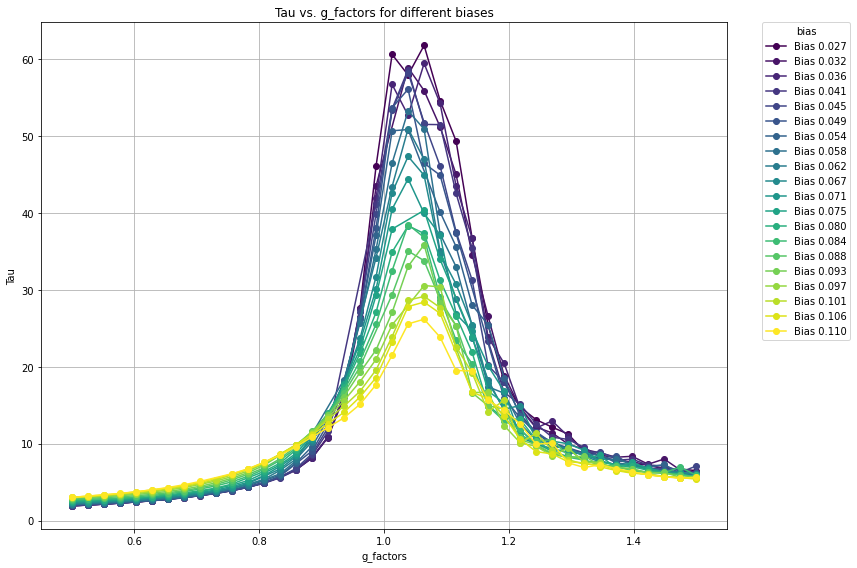

In [ ]:
cmap = plt.get_cmap('viridis')  
colors = [cmap(i / 19) for i in range(20)]  

plt.figure(figsize=(12, 8))

for i in range(20):
    not_nan = ~np.isnan(tau_array[i, :])
    plt.plot(g_factors[not_nan], tau_array[i, not_nan], label=f'Bias {bias_values[i]:.3f}', color=colors[i], marker='o')


plt.title('Tau vs. g_factors for different biases')
plt.xlabel('g_factors')
plt.ylabel('Tau')
plt.legend(title='bias', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)

plt.tight_layout()
plt.savefig('Tau_vs_g_factors.png') 
plt.show()


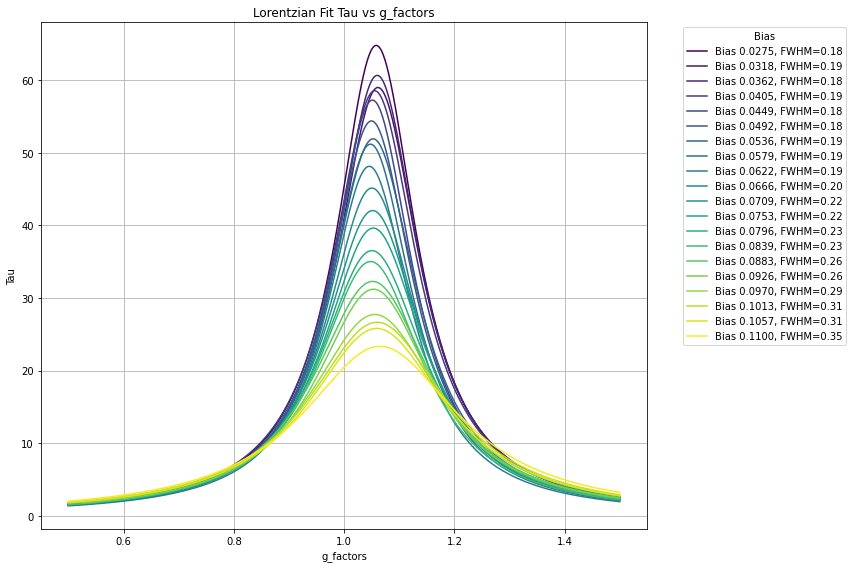

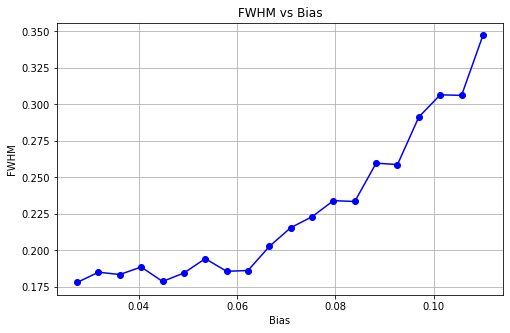

In [139]:

def lorentzian(x, A, x0, gamma):
    return (A * gamma**2) / ((x - x0)**2 + gamma**2)

fwhm_values = []  

plt.figure(figsize=(12, 8))
colors = plt.get_cmap('viridis')(np.linspace(0, 1, 20))

for i in range(20):
    row_data = tau_array[i, :]
    not_nan = ~np.isnan(row_data)
    x_data, y_data = g_factors[not_nan], row_data[not_nan]

    popt, _ = curve_fit(lorentzian, x_data, y_data, p0=[np.max(y_data), x_data[np.argmax(y_data)], 1.0])
    A_fit, x0_fit, gamma_fit = popt
    fwhm = 2 * abs(gamma_fit)
    fwhm_values.append(fwhm)

    x_fit = np.linspace(x_data.min(), x_data.max(), 1000)
    y_fit = lorentzian(x_fit, *popt)

    plt.plot(x_fit, y_fit, label=f'Bias {bias_values[i]:.4f}, FWHM={fwhm:.2f}', color=colors[i])


plt.title('Lorentzian Fit Tau vs g_factors')
plt.xlabel('g_factors')
plt.ylabel('Tau')
plt.legend(title='Bias', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('Lorentzian_vs_g_factors.png') 
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(bias_values, fwhm_values, marker='o', color='b')
plt.title('FWHM vs Bias')
plt.xlabel('Bias')
plt.ylabel('FWHM')
plt.savefig('FWHM(bias).png') 
plt.grid(True)
plt.show()

In [134]:
np.save('g_factors.npy', g_factors)
np.save('bias_values.npy', bias_values)
np.save('tau_values.npy', tau_array)